In [3]:
import sys
print(sys.version)
%matplotlib inline
%run -i ~/Python/pjr3

3.7.10 | packaged by conda-forge | (default, Feb 19 2021, 16:07:37) 
[GCC 9.3.0]
pjr3.py complete


In [4]:
indir = os.path.expanduser('~/NetCDF_Files/*F2010*.nc')
#indir = os.path.expanduser('/lustre/choi040/20210920.F2010.1Nudg.ne30pg2_r05_oECv3/run/20210920.F2010.1Nudg.ne30pg2_r05_oECv3.eam.h2.2015-01-01-00000.nc')
#indir = os.path.expanduser('~/NetCDF_Files/*F2010*01.nc')
#indir = os.path.expanduser('~/NetCDF_Files/vd05_ANN_climo.nc')

print(indir)
#print('exists',os.path.exists(indir))
DS = xr.open_mfdataset(indir).chunk({'time': 20})
print('DS',DS)
weights = DS.area
weights.name = 'weights'
Var = DS.FSNT - DS.FLNT  # net radiative flux at Top of Model
print(Var.shape)
Varm2 = Var.weighted(weights).mean() # calculate global average
print('area weighted mean', Varm2.values)

/home/d3x345/NetCDF_Files/*F2010*.nc
DS <xarray.Dataset>
Dimensions:              (cosp_ht: 40, cosp_htmisr: 16, cosp_prs: 7, cosp_reffice: 6, cosp_reffliq: 6, cosp_scol: 10, cosp_sr: 15, cosp_sza: 5, cosp_tau: 7, cosp_tau_modis: 7, ilev: 73, lev: 72, nbnd: 2, ncol: 21600, time: 1)
Coordinates: (12/13)
  * lev                  (lev) float64 0.1238 0.1828 0.2699 ... 993.8 998.5
  * ilev                 (ilev) float64 0.1 0.1477 0.218 ... 990.5 997.0 1e+03
  * cosp_prs             (cosp_prs) float64 9e+04 7.4e+04 ... 2.45e+04 9e+03
  * cosp_tau             (cosp_tau) float64 0.15 0.8 2.45 6.5 16.2 41.5 100.0
  * cosp_scol            (cosp_scol) int32 1 2 3 4 5 6 7 8 9 10
  * cosp_ht              (cosp_ht) float64 1.896e+04 1.848e+04 ... 720.0 240.0
    ...                   ...
  * cosp_sza             (cosp_sza) float64 0.0 20.0 40.0 60.0 80.0
  * cosp_htmisr          (cosp_htmisr) float64 0.0 250.0 ... 1.6e+04 1.8e+04
  * cosp_tau_modis       (cosp_tau_modis) float64 0.15 0.8 2.45 ... 

In [20]:
# interpolate xarray datavariable on eta hybrid surfaces to 20 pressure levels
Tin = DS.T
Tin = Tin.squeeze()
#print("Tin",Tin)

# calculate the pressure levels for the model from PS and the hybrid coordinates
Pin = (DS.hyam*DS.P0 + DS.hybm*DS.PS)/100.
Pin.attrs["units"] = 'hPa'
Pin.attrs["long_name"] = 'Pressure'
Pin = Pin.squeeze()

# specify the pressures to interpolate to
nzout = 20
pout = np.linspace(1.,1000.,nzout)


Tout = hy2plev(Tin, Pin, pout)
print('Tout',Tout)

Tout <xarray.DataArray (plev: 20, ncol: 21600)>
array([[271.34369036, 271.60821973, 270.85561151, ..., 261.17912028,
        261.05758394, 261.75698552],
       [209.76276985, 210.19728329, 208.91364178, ..., 213.01031739,
        213.02083721, 212.54169384],
       [205.57679609, 206.21874757, 204.25291223, ..., 214.64601495,
        215.09560119, 213.71565609],
       ...,
       [286.71875458, 285.82384864, 288.06011056, ..., 268.72276266,
        268.81780186, 269.50521302],
       [289.1575551 , 288.4132077 , 290.30984252, ..., 272.84250703,
        272.77699011, 273.48002961],
       [292.51175788, 291.84400507, 293.51074954, ..., 277.04700011,
                 nan, 277.57471982]])
Coordinates:
    time     object 2015-02-01 00:00:00
  * plev     (plev) float64 1.0 53.58 106.2 158.7 ... 842.3 894.8 947.4 1e+03
Dimensions without coordinates: ncol
Attributes:
    mdims:          1
    units:          K
    long_name:      Temperature
    standard_name:  air_temperature
    cell_me

In [50]:
def gcd(lon1, lat1, lon2, lat2):
    """calculate great circle distance in km
       given input longitude and latitudes in degrees
    """
    d2r = 57.296
    lonr1 = lon1/d2r
    latr1 = lat1/d2r
    lonr2 = lon2/d2r
    latr2 = lat2/d2r

    d = 6371.*(np.arccos(np.sin(latr1) * np.sin(latr2) + np.cos(latr1) * np.cos(latr2) * np.cos(lonr1 - lonr2)))
    return d

lat = DS['lat'].values#[0,:]
lon = DS['lon'].values#[0,:]
print('xxx',lat[10],lon[10])
tlon = 321.6
tlat = -35.8
dd = gcd(lon,lat, tlon, tlat)

ind = np.where(dd == np.min(dd))
ind = int(ind[0])
print('ind',ind,lat[ind],lon[ind])

xxx -35.98099838266331 321.74210020666715
dd [  540.38295277   394.4019203    592.90062286 ... 19282.46218004
 19547.86751034 19420.37110259] (21600,) 23.851997976360476
ind 10 -35.98099838266331 321.74210020666715


dist 0.7500003953503928 -88.93939984132163 117.94418571451939
xxx 1.061000000000007
ind 16260 -88.93939984132163 44.99999999999992


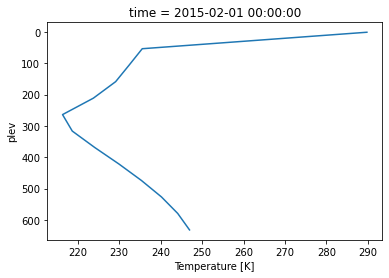

In [53]:
# plot a column specified by xlook and ylook for fields specified on a cubed sphere grid
xlook = 0.
ylook = -90.
lat = DS['lat'].values#[0,:]
lon = DS['lon'].values#[0,:]
#dist = np.abs(ylook-lat) + np.abs(xlook-lon)
dist = gcd(lon,lat, xlook, ylook)

print('dist',lon.min(),lat.min(),dist.min())
print('xxx',-88.939-ylook)
# find the index closest to xlook ylook
ind = np.where(dist == np.min(dist))
ind = int(ind[0])
print('ind',ind,lat[ind],lon[ind])
Toutm = Tout[:,ind]
pl = Toutm.plot(y="plev",yincrease=False)

dmin,dmax 261.02763839817175 297.5479075776443


<function matplotlib.pyplot.show(close=None, block=None)>

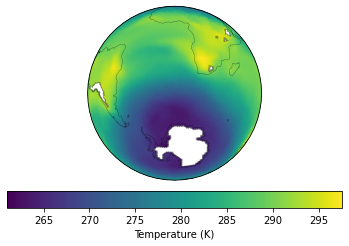

In [13]:
# a simple method to plot a horizontal field using a map projection.
# this method is fine for plots where you dont care too much about the exact shape of the cells
# the plot uses triangulation from cell center to cell center. Other methods are better for knowing exactly the shape of each cell

indir = os.path.expanduser('/lustre/choi040/20210920.F2010.1Nudg.ne30pg2_r05_oECv3/run/20210920.F2010.1Nudg.ne30pg2_r05_oECv3.eam.h0.2015-01.nc')
DS = xr.open_mfdataset(indir).chunk({'time': 20})
Tout = DS.PS.isel(time=0)
#indir = os.path.expanduser('/lustre/choi040/20210920.F2010.1Nudg.ne30pg2_r05_oECv3/run/20210920.F2010.1Nudg.ne30pg2_r05_oECv3.eam.h2.2015-01-01-00000.nc')
#DS = xr.open_mfdataset(indir).chunk({'time': 20})
#Tout = DS.T850.isel(time=0)

gridfile = '/lustre/d3x345/maps/ne30pg2_scrip_c20191218.nc'

Tin = DS.T
Tin = Tin.squeeze()

Pin = (DS.hyam*DS.P0 + DS.hybm*DS.PS)/100.
Pin.attrs["units"] = 'hPa'
Pin.attrs["long_name"] = 'Pressure'
Pin = Pin.squeeze()

pout = 850.

Tout2 = hy2plev(Tin, Pin, pout).squeeze()

# Read data
data = Tout2

lon = DS['lon']
lat = DS['lat']

dataproj=ccrs.PlateCarree()    # data is always assumed to be lat/lon
plotproj=ccrs.Orthographic(central_latitude=-50)   # any projections should work 
ax = plt.axes(projection=plotproj)
ax.set_global()
ax.coastlines(linewidth=0.2)

tcoords = plotproj.transform_points(dataproj,np.array(lon[:]),np.array(lat[:]))
data2d = data
xi=tcoords[:,0]!=np.inf
tc=tcoords[xi,:]
datai=data2d[:][xi]  # convert to numpy array, then subset
dmin = datai.min().values
dmax = datai.max().values
print('dmin,dmax',dmin,dmax)
pl = ax.tripcolor(tc[:,0],tc[:,1], datai,shading='gouraud',vmin=dmin,vmax=dmax) # looks good
#pl = ax.tripcolor(tc[:,0],tc[:,1], datai,shading='flat') # looks bad
# Add colorbar to plot
cb = plt.colorbar(
    pl, orientation='horizontal',
    label='%s (%s)'%(data.long_name, data.units), pad=0.05
)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

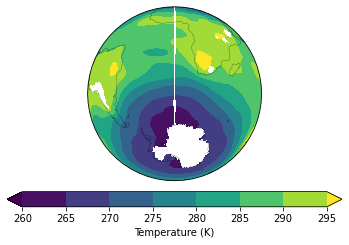

In [14]:
# create a regular lat/lon grid
# OK for quick and dirty plotting, but leaves NaNs near domain edges
from scipy.interpolate import griddata
import numpy

xi = numpy.linspace(0, 360, 361)  # to regrid to 1/2 degree
yi = numpy.linspace(-90, 90, 181)  # to regrid to 1/2 degree

data_regridded = griddata((lon, lat), data2d, (xi[None,:], yi[:,None]), method='linear')
df = data_regridded.flatten()
dsub = df[np.isfinite(df)] # ignore NaN
zmax = dsub.max()
zmin = dsub.min()

dataproj=ccrs.PlateCarree()    # data is always assumed to be lat/lon
plotproj=ccrs.Orthographic(central_latitude=-50)   # any projections should work 
ax = plt.axes(projection=plotproj)
ax.set_global()
ax.coastlines(linewidth=0.2)
clevs = findNiceContours(np.array([dmin,dmax]),nlevs=10)
pl = ax.contourf(xi, yi, data_regridded, clevs, vmin=dmin, vmax=dmax,  extend='both', transform=ccrs.PlateCarree())
# Add colorbar to plot
cb = plt.colorbar(
    pl, orientation='horizontal',ticks=clevs,
    label='%s (%s)'%(data.long_name, data.units), pad=0.05
)
plt.show